In [19]:
import torch

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

from skimage import transform
from torch.utils.data import DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [20]:
from dataset import *
from show import *

# Loading Dataset

In [10]:
dset = BuildingsDataset("data/labels")

In [11]:
idx = 0
sample = dset[idx]
img, lbl = sample['image'], sample['label']
label_names = dset.label_name_to_value

print(img.shape, img.dtype)
print(lbl.shape, lbl.dtype)
print(label_names)

(2048, 3072, 3) float32
(2048, 3072) uint8
{'_background_': 0, 'door': 1, 'object': 2, 'wall': 3, 'window': 4}


# Displaying data

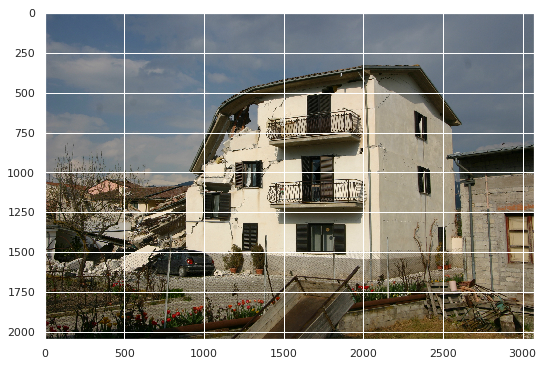

In [21]:
plt.imshow(img)
plt.show()

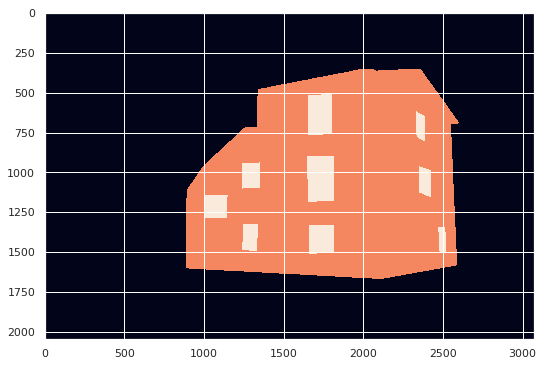

In [22]:
plt.imshow(lbl)
plt.show()

(2048, 3072, 3) (2048, 3072)


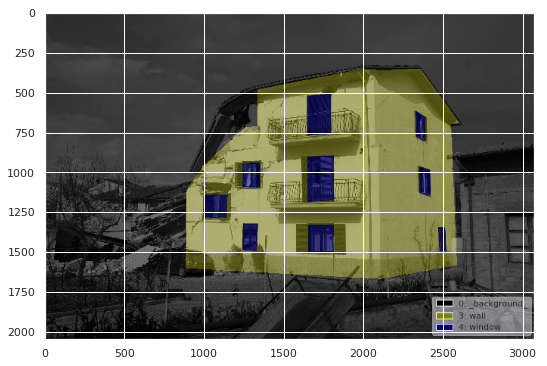

In [23]:
show_labeled_img(img, lbl, label_names)

# Going further

In [15]:
data_transform1 = transforms.Compose([
    #Rescale(1024),
    RandomCrop(512), 
    ToTensor(),
])

# not working with dict
data_transform2 = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [16]:
dset_tensor = BuildingsDataset("data/labels", transform=data_transform1)
dataloader = DataLoader(dset_tensor, batch_size=4, shuffle=True, num_workers=0)

0 torch.Size([4, 3, 512, 512]) torch.Size([4, 512, 512])
(516, 2058, 3) (516, 2058)


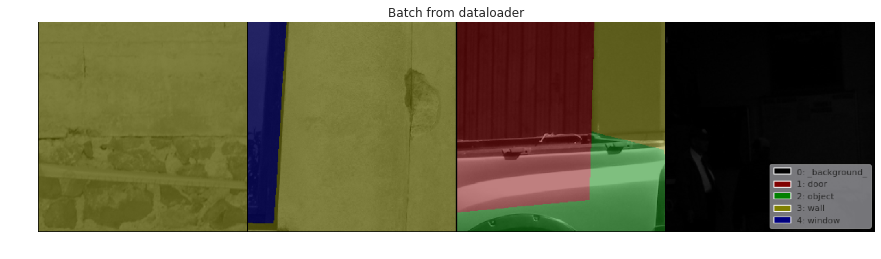

In [30]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'].size())

    # observe 2 batches and stop.
    if i_batch == 0:
        plt.figure()
        show_batch(sample_batched, label_names, 4)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break